# 00: JUMP-CP Data Exploration

This notebook demonstrates ProToPhen's interface with the
[JUMP Cell Painting](https://jump-cellpainting.broadinstitute.org/) consortium
dataset (Chandrasekaran *et al.*, 2023). The full dataset spans >100 TB of
high-content imaging data across >136,000 perturbations in U2OS cells. Our
infrastructure enables intelligent subsetting, caching, and curation for
model pre-training.

**Contents**

1. [Setup & Connectivity](#1-setup--connectivity)
2. [Metadata Exploration](#2-metadata-exploration)
3. [Plate Profiles](#3-plate-profiles)
4. [Quality Control](#4-quality-control)
5. [Feature Selection & Normalisation](#5-feature-selection--normalisation)
6. [Pre-training Data Curation](#6-pre-training-data-curation)
7. [Bridge to ProToPhen Data Structures](#7-bridge-to-protophen-data-structures)
8. [Gene → Protein Sequence Mapping](#8-gene--protein-sequence-mapping)
9. [Summary & Next Steps](#9-summary--next-steps)

> **Note:** Cells that download data from S3 or the internet are guarded with
> connectivity checks. The notebook can be run fully offline if the cache has
> been populated by a prior `scripts/download_jumpcp.py` run.

---
## 1. Setup & Connectivity

In [1]:
# Standard imports
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# ProToPhen JUMP-CP imports
from protophen.data.jumpcp import (
    JUMPCPAccess,
    JUMPCPConfig,
    JUMPCPCache,
    JUMPCPMetadata,
    ProfileLoader,
    CurationConfig,
    DataCurator,
    QualityController,
)
from protophen.data.jumpcp.profiles import (
    identify_feature_columns,
    identify_metadata_columns,
)
from protophen.phenotype.normalisation import (
    BatchCorrector,
    FeatureSelector,
    Normaliser,
)
from protophen.data.phenotype import PhenotypeDataset
from protophen.utils.logging import setup_logging

# Visualisation defaults
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 120

setup_logging(level="INFO")

print("Imports complete")

Imports complete


In [2]:
# Load configuration (use default or custom YAML)
config_path = Path("../configs/jumpcp.yaml")

if config_path.exists():
    config = JUMPCPConfig.from_yaml(config_path)
    print(f"✓ Loaded config from {config_path}")
else:
    config = JUMPCPConfig()
    print("✓ Using default JUMPCPConfig")

# Optionally override cache directory for notebook use
# config.cache_dir = "./data/raw/jumpcp"

print(f"  S3 bucket:  {config.s3_bucket}")
print(f"  S3 prefix:  {config.s3_prefix}")
print(f"  Cache dir:  {config.cache_dir}")

✓ Loaded config from ..\configs\jumpcp.yaml
  S3 bucket:  cellpainting-gallery
  S3 prefix:  cpg0016-jump
  Cache dir:  ./data/raw/jumpcp


In [3]:
# Initialise access layer and check connectivity
access = JUMPCPAccess(config=config)
connectivity = access.check_connectivity()

print(f"\nConnectivity:")
print(f"  S3 (boto3):  {'✓' if connectivity['s3'] else '  (install boto3 for S3 access)'}")
print(f"  HTTPS:       {'✓' if connectivity['https'] else '  (check network)'}")

HAS_S3 = connectivity["s3"]
HAS_HTTPS = connectivity["https"]
HAS_NETWORK = HAS_S3 or HAS_HTTPS

2026-02-15 23:23:00 | INFO     | protophen.data.jumpcp.access:__init__:167 | Initialised JUMPCPAccess
2026-02-15 23:23:01 | INFO     | protophen.data.jumpcp.access:check_connectivity:232 | Connectivity: S3=True, HTTPS=True



Connectivity:
  S3 (boto3):  ✓
  HTTPS:       ✓


In [4]:
# Cache status
cache_info = access.cache.get_cache_info()
print(f"\nCache status:")
for key, val in cache_info.items():
    if isinstance(val, float):
        print(f"  {key}: {val:.3f}")
    else:
        print(f"  {key}: {val}")


Cache status:
  cache_dir: data\raw\jumpcp
  total_entries: 8
  total_size_gb: 0.110
  max_size_gb: 50.000
  n_profiles: 3
  n_metadata: 5
  profile_size_gb: 0.104


---
## 2. Metadata Exploration

JUMP-CP metadata is distributed as CSV files on GitHub. Our
`JUMPCPMetadata` class fetches, caches, and provides structured access.

In [5]:
# Initialise metadata manager
meta = JUMPCPMetadata(access=access)

if HAS_NETWORK:
    # Fetch key metadata tables
    print("Fetching metadata tables...")
    orf_df = access.fetch_metadata_table("orf")
    plate_df = access.fetch_metadata_table("plate")
    
    print(f"\nORF metadata:   {orf_df.shape[0]:,} rows × {orf_df.shape[1]} columns")
    print(f"Plate metadata: {plate_df.shape[0]:,} rows × {plate_df.shape[1]} columns")
else:
    print("No network — using cached data or skipping metadata exploration.")
    orf_df = access.cache.get_metadata("orf")
    plate_df = access.cache.get_metadata("plate")
    if orf_df is not None:
        print(f"Loaded ORF metadata from cache: {len(orf_df):,} rows")
    if plate_df is not None:
        print(f"Loaded plate metadata from cache: {len(plate_df):,} rows")

Fetching metadata tables...

ORF metadata:   15,132 rows × 12 columns
Plate metadata: 2,525 rows × 4 columns


In [6]:
# Inspect ORF metadata columns
if orf_df is not None:
    print("ORF metadata columns:")
    for col in orf_df.columns:
        n_unique = orf_df[col].nunique()
        print(f"  {col:40s}  {n_unique:>8,} unique values")
    
    print(f"\nFirst 5 rows:")
    display_df = orf_df.head()
    print(display_df.to_string(index=False))
else:
    print("ORF metadata not available.")

ORF metadata columns:
  Metadata_JCP2022                            15,132 unique values
  Metadata_broad_sample                       15,132 unique values
  Metadata_Name                               15,132 unique values
  Metadata_Vector                                  1 unique values
  Metadata_Transcript                         13,553 unique values
  Metadata_Symbol                             12,602 unique values
  Metadata_NCBI_Gene_ID                       12,602 unique values
  Metadata_Taxon_ID                                2 unique values
  Metadata_Gene_Description                   12,452 unique values
  Metadata_Prot_Match                            904 unique values
  Metadata_Insert_Length                       1,667 unique values
  Metadata_pert_type                               3 unique values

First 5 rows:
Metadata_JCP2022 Metadata_broad_sample        Metadata_Name Metadata_Vector Metadata_Transcript Metadata_Symbol Metadata_NCBI_Gene_ID Metadata_Taxon_ID        

In [7]:
# Inspect plate metadata
if plate_df is not None:
    print("Plate metadata columns:")
    for col in plate_df.columns:
        n_unique = plate_df[col].nunique()
        print(f"  {col:40s}  {n_unique:>8,} unique values")
    
    print(f"\nFirst 5 rows:")
    display_df = plate_df.head()
    print(display_df.to_string(index=False))
else:
    print("Plate metadata not available.")

Plate metadata columns:
  Metadata_Source                                 13 unique values
  Metadata_Batch                                 149 unique values
  Metadata_Plate                               2,525 unique values
  Metadata_PlateType                               8 unique values

First 5 rows:
Metadata_Source  Metadata_Batch Metadata_Plate Metadata_PlateType
       source_1 Batch1_20221004       UL000109     COMPOUND_EMPTY
       source_1 Batch1_20221004       UL001641           COMPOUND
       source_1 Batch1_20221004       UL001643           COMPOUND
       source_1 Batch1_20221004       UL001645           COMPOUND
       source_1 Batch1_20221004       UL001651           COMPOUND


In [8]:
# Gene counts by perturbation type
if orf_df is not None:
    orf_genes = meta.get_orf_genes()
    print(f"ORF overexpression genes: {len(orf_genes):,}")

    # Show example genes
    print(f"  Examples: {orf_genes[:10]}")

2026-02-15 23:23:02 | INFO     | protophen.data.jumpcp.metadata:get_orf_genes:98 | ORF set contains 12602 unique genes


ORF overexpression genes: 12,602
  Examples: ['A1BG', 'A1CF', 'A2M', 'A4GALT', 'A4GNT', 'AAAS', 'AADAC', 'AADAT', 'AAGAB', 'AAK1']


In [9]:
if HAS_NETWORK:
    try:
        crispr_genes = meta.get_crispr_genes()
        print(f"CRISPR knockout genes:   {len(crispr_genes):,}")
        print(f"  Examples: {crispr_genes[:10]}")
    except Exception as e:
        print(f"Could not fetch CRISPR genes: {e}")

2026-02-15 23:23:02 | INFO     | protophen.data.jumpcp.metadata:get_crispr_genes:106 | CRISPR set contains 7977 unique genes


CRISPR knockout genes:   7,977
  Examples: ['A2M', 'A3GALT2', 'A4GALT', 'A4GNT', 'AACS', 'AADAC', 'AADAT', 'AAK1', 'AANAT', 'AARS']


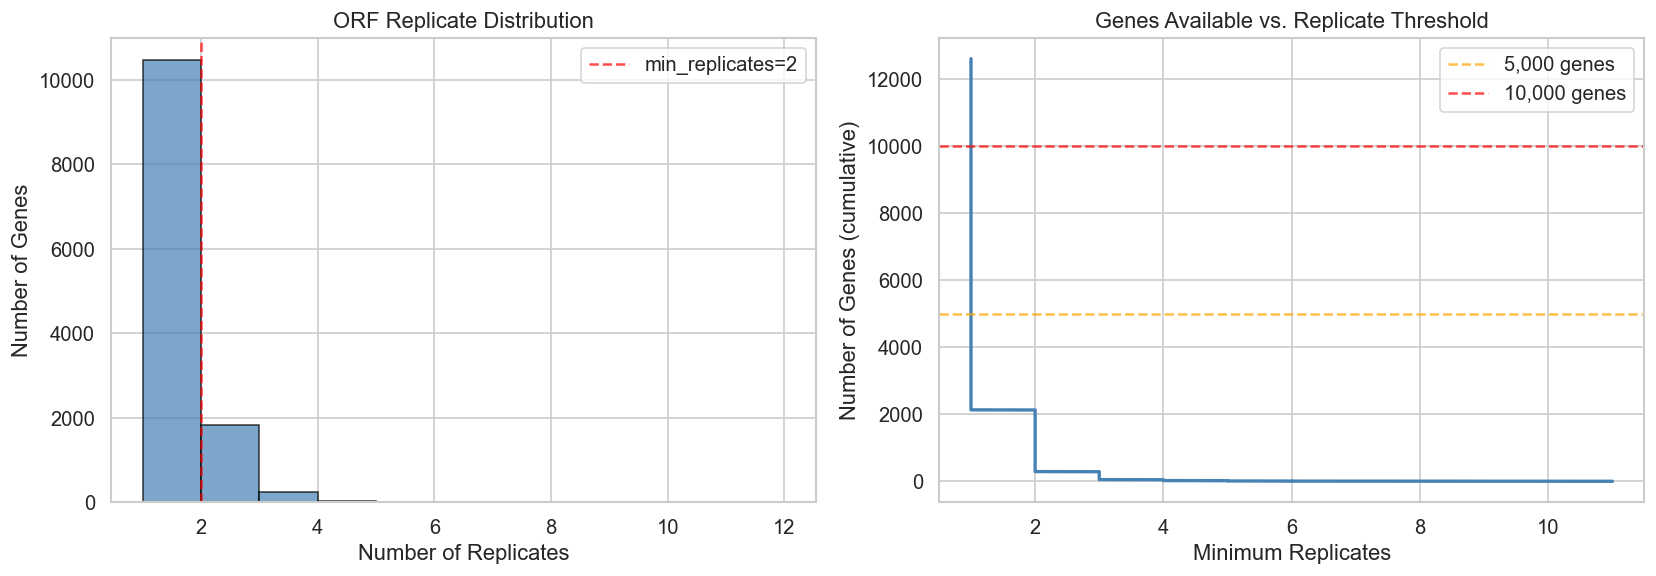


Replicate statistics:
  Total genes:       12,602
  Genes with ≥2 reps: 2,127
  Genes with ≥3 reps: 286
  Genes with ≥5 reps: 18
  Mean replicates:   1.2
  Median replicates: 1


In [10]:
# Replicate distribution
if orf_df is not None:
    rep_counts = meta.count_replicates("orf")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram of replicate counts
    axes[0].hist(
        rep_counts["n_replicates"],
        bins=range(1, rep_counts["n_replicates"].max() + 2),
        edgecolor="black",
        alpha=0.7,
        color="steelblue",
    )
    axes[0].set_xlabel("Number of Replicates")
    axes[0].set_ylabel("Number of Genes")
    axes[0].set_title("ORF Replicate Distribution")
    axes[0].axvline(x=2, color="red", linestyle="--", alpha=0.7, label="min_replicates=2")
    axes[0].legend()
    
    # Cumulative distribution
    sorted_reps = np.sort(rep_counts["n_replicates"].values)[::-1]
    cumulative = np.arange(1, len(sorted_reps) + 1)
    axes[1].plot(sorted_reps, cumulative, linewidth=2, color="steelblue")
    axes[1].set_xlabel("Minimum Replicates")
    axes[1].set_ylabel("Number of Genes (cumulative)")
    axes[1].set_title("Genes Available vs. Replicate Threshold")
    axes[1].axhline(y=5000, color="orange", linestyle="--", alpha=0.7, label="5,000 genes")
    axes[1].axhline(y=10000, color="red", linestyle="--", alpha=0.7, label="10,000 genes")
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig("../outputs/jumpcp_replicate_distribution.png", bbox_inches="tight")
    plt.show()
    
    # Summary statistics
    print(f"\nReplicate statistics:")
    print(f"  Total genes:       {len(rep_counts):,}")
    print(f"  Genes with ≥2 reps: {(rep_counts['n_replicates'] >= 2).sum():,}")
    print(f"  Genes with ≥3 reps: {(rep_counts['n_replicates'] >= 3).sum():,}")
    print(f"  Genes with ≥5 reps: {(rep_counts['n_replicates'] >= 5).sum():,}")
    print(f"  Mean replicates:   {rep_counts['n_replicates'].mean():.1f}")
    print(f"  Median replicates: {rep_counts['n_replicates'].median():.0f}")

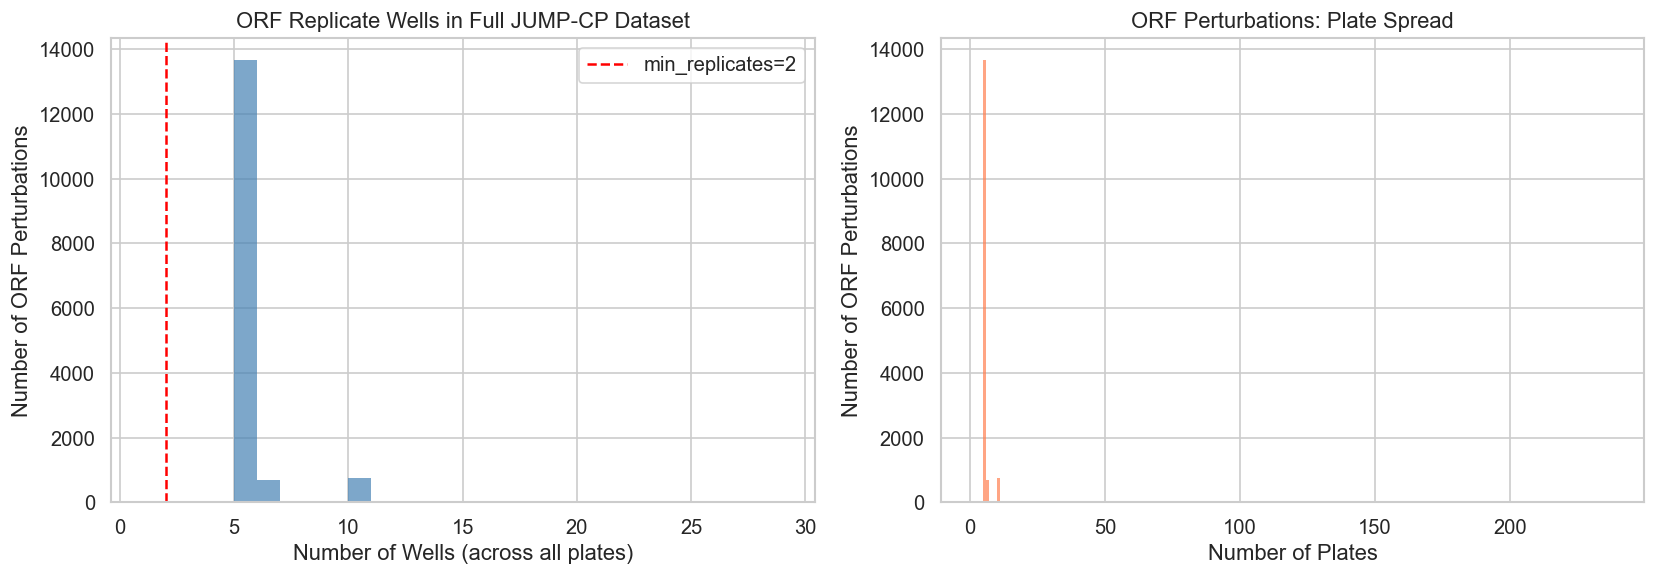

Full dataset ORF replicate statistics:
  Total ORF JCP2022 codes:     15,132
  ORF wells in well table:     86,699
  Mean wells per perturbation: 5.7
  Median wells per perturbation: 5
  Perturbations with ≥2 wells: 15,132
  Perturbations with ≥3 wells: 15,132

  → With 10 plates, expect ~14,720 wells
  → Most perturbations appear on 1–2 plates
  → Use min_replicates=1 for small tests, ≥2 for full runs


In [11]:
# Replicate analysis: well table vs. ORF table
# The replicate distribution above comes from the ORF metadata table, which counts entries per JCP2022 code. 
# But "replicates" in the context of our curation pipeline means "how many wells across our LOADED plates contain the same gene?" 
# With only 3 plates, most genes appear once.

# Set N_PLATES_DEMO to the number of plates we have loaded in this demo (e.g. 10)
N_PLATES_DEMO = 10

if orf_df is not None and HAS_NETWORK:
    try:
        well_df = access.fetch_metadata_table("well")
        
        # How many wells per JCP2022 across ALL plates?
        wells_per_jcp = well_df.groupby("Metadata_JCP2022").size()
        
        # How many are ORF wells? (merge with orf table)
        orf_jcp_ids = set(orf_df["Metadata_JCP2022"].unique())
        orf_wells = well_df[well_df["Metadata_JCP2022"].isin(orf_jcp_ids)]
        orf_wells_per_gene = orf_wells.groupby("Metadata_JCP2022").size()
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        axes[0].hist(orf_wells_per_gene.values, bins=range(1, 30),
                     alpha=0.7, color="steelblue", edgecolor="none")
        axes[0].set_xlabel("Number of Wells (across all plates)")
        axes[0].set_ylabel("Number of ORF Perturbations")
        axes[0].set_title("ORF Replicate Wells in Full JUMP-CP Dataset")
        axes[0].axvline(x=2, color="red", linestyle="--", label="min_replicates=2")
        axes[0].legend()
        
        # How many unique plates contain ORF wells?
        orf_plates = orf_wells.groupby("Metadata_JCP2022")["Metadata_Plate"].nunique()
        axes[1].hist(orf_plates.values, bins=range(1, orf_plates.max() + 2),
                     alpha=0.7, color="coral", edgecolor="none")
        axes[1].set_xlabel("Number of Plates")
        axes[1].set_ylabel("Number of ORF Perturbations")
        axes[1].set_title("ORF Perturbations: Plate Spread")
        
        plt.tight_layout()
        plt.savefig("../outputs/jumpcp_orf_replicates_full.png", bbox_inches="tight")
        plt.show()
        
        print(f"Full dataset ORF replicate statistics:")
        print(f"  Total ORF JCP2022 codes:     {len(orf_jcp_ids):,}")
        print(f"  ORF wells in well table:     {len(orf_wells):,}")
        print(f"  Mean wells per perturbation: {orf_wells_per_gene.mean():.1f}")
        print(f"  Median wells per perturbation: {orf_wells_per_gene.median():.0f}")
        print(f"  Perturbations with ≥2 wells: {(orf_wells_per_gene >= 2).sum():,}")
        print(f"  Perturbations with ≥3 wells: {(orf_wells_per_gene >= 3).sum():,}")
        
        print(f"\n  → With {N_PLATES_DEMO} plates, expect ~{N_PLATES_DEMO * 1472:,} wells")
        print(f"  → Most perturbations appear on 1–2 plates")
        print(f"  → Use min_replicates=1 for small tests, ≥2 for full runs")
        
    except Exception as e:
        print(f"Could not perform cross-plate analysis: {e}")

---
## 3. Plate Profiles

Morphological profiles are stored as Parquet files on S3, one per plate.
Each file contains well-level aggregated CellProfiler features.

We load a single plate to inspect the data structure.

In [12]:
# Get the plate → source/batch mapping for ORF plates
if plate_df is not None:
    try:
        plate_map = meta.get_plate_batch_source_map("orf")
        print(f"ORF plate map: {len(plate_map)} entries")
        print(plate_map.head(10).to_string(index=False))
    except Exception as e:
        plate_map = None
        print(f"Could not build plate map: {e}")
else:
    plate_map = None
    print("Plate metadata not available.")

2026-02-15 23:23:04 | INFO     | protophen.data.jumpcp.metadata:get_plates_for_perturbation:273 | Found 251 plates for perturbation type 'orf'
2026-02-15 23:23:04 | INFO     | protophen.data.jumpcp.metadata:get_plate_batch_source_map:372 | Plate→source/batch mapping: 251 entries (orf)


ORF plate map: 251 entries
     plate   source             batch
BR00117035 source_4 2021_04_26_Batch1
BR00117036 source_4 2021_04_26_Batch1
BR00117037 source_4 2021_04_26_Batch1
BR00117038 source_4 2021_04_26_Batch1
BR00117039 source_4 2021_04_26_Batch1
BR00117040 source_4 2021_04_26_Batch1
BR00117041 source_4 2021_04_26_Batch1
BR00121537 source_4 2021_04_26_Batch1
BR00121538 source_4 2021_04_26_Batch1
BR00121539 source_4 2021_04_26_Batch1


In [13]:
# Load a single plate
loader = ProfileLoader(access=access, metadata=meta)

sample_plate_df = None

if plate_map is not None and HAS_S3 and len(plate_map) > 0:
    # Pick the first available plate
    sample_row = plate_map.iloc[0]
    print(f"Loading plate: {sample_row['plate']}")
    print(f"  Source: {sample_row['source']}")
    print(f"  Batch:  {sample_row['batch']}")
    
    try:
        sample_plate_df = loader.load_plate_profiles(
            source=sample_row["source"],
            batch=sample_row["batch"],
            plate=sample_row["plate"],
        )
        print(f"\nLoaded: {sample_plate_df.shape[0]} wells x {sample_plate_df.shape[1]} columns")
    except Exception as e:
        print(f"Failed to load plate: {e}")
        print("  (This may require boto3 + s3fs to be installed)")
elif plate_map is not None and len(plate_map) > 0:
    # Try loading from cache
    sample_row = plate_map.iloc[0]
    cache_key = f"{sample_row['source']}__{sample_row['batch']}__{sample_row['plate']}"
    sample_plate_df = access.cache.get_profiles(cache_key)
    if sample_plate_df is not None:
        print(f"✓ Loaded plate '{sample_row['plate']}' from cache")
        loader._feature_columns = identify_feature_columns(sample_plate_df)
    else:
        print("No cached plate profiles available.")
else:
    print("No plate map available — skipping profile loading.")

2026-02-15 23:23:04 | INFO     | protophen.data.jumpcp.access:fetch_plate_profiles:526 | Fetching profiles for plate 'BR00117035' from S3


Loading plate: BR00117035
  Source: source_4
  Batch:  2021_04_26_Batch1


2026-02-15 23:23:11 | INFO     | protophen.data.jumpcp.profiles:load_plate_profiles:151 | Plate 'BR00117035': 384 wells, 3646 features



Loaded: 384 wells x 4765 columns


In [14]:
# Inspect the plate structure
if sample_plate_df is not None:
    feature_cols = loader.feature_columns or identify_feature_columns(sample_plate_df)
    meta_cols = identify_metadata_columns(sample_plate_df)
    
    print(f"Metadata columns ({len(meta_cols)}):")
    for col in meta_cols:
        print(f"  {col}: {sample_plate_df[col].nunique()} unique values")
    
    print(f"\nFeature columns ({len(feature_cols)}):")
    print(f"  First 10: {feature_cols[:10]}")
    print(f"  Last 5:   {feature_cols[-5:]}")
    
    # Feature compartment breakdown
    compartment_counts = {}
    for f in feature_cols:
        comp = f.split("_")[0]
        compartment_counts[comp] = compartment_counts.get(comp, 0) + 1
    
    print(f"\nFeatures per compartment:")
    for comp, count in sorted(compartment_counts.items()):
        print(f"  {comp}: {count}")

Metadata columns (3):
  Metadata_Source: 1 unique values
  Metadata_Plate: 1 unique values
  Metadata_Well: 384 unique values

Feature columns (3646):
  First 10: ['Cells_AreaShape_Area', 'Cells_AreaShape_BoundingBoxArea', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_Compactness', 'Cells_AreaShape_Eccentricity', 'Cells_AreaShape_EquivalentDiameter', 'Cells_AreaShape_EulerNumber', 'Cells_AreaShape_Extent', 'Cells_AreaShape_FormFactor']
  Last 5:   ['Nuclei_Texture_Variance_RNA_3_03_256', 'Nuclei_Texture_Variance_RNA_5_00_256', 'Nuclei_Texture_Variance_RNA_5_01_256', 'Nuclei_Texture_Variance_RNA_5_02_256', 'Nuclei_Texture_Variance_RNA_5_03_256']

Features per compartment:
  Cells: 1246
  Cytoplasm: 1236
  Nuclei: 1164


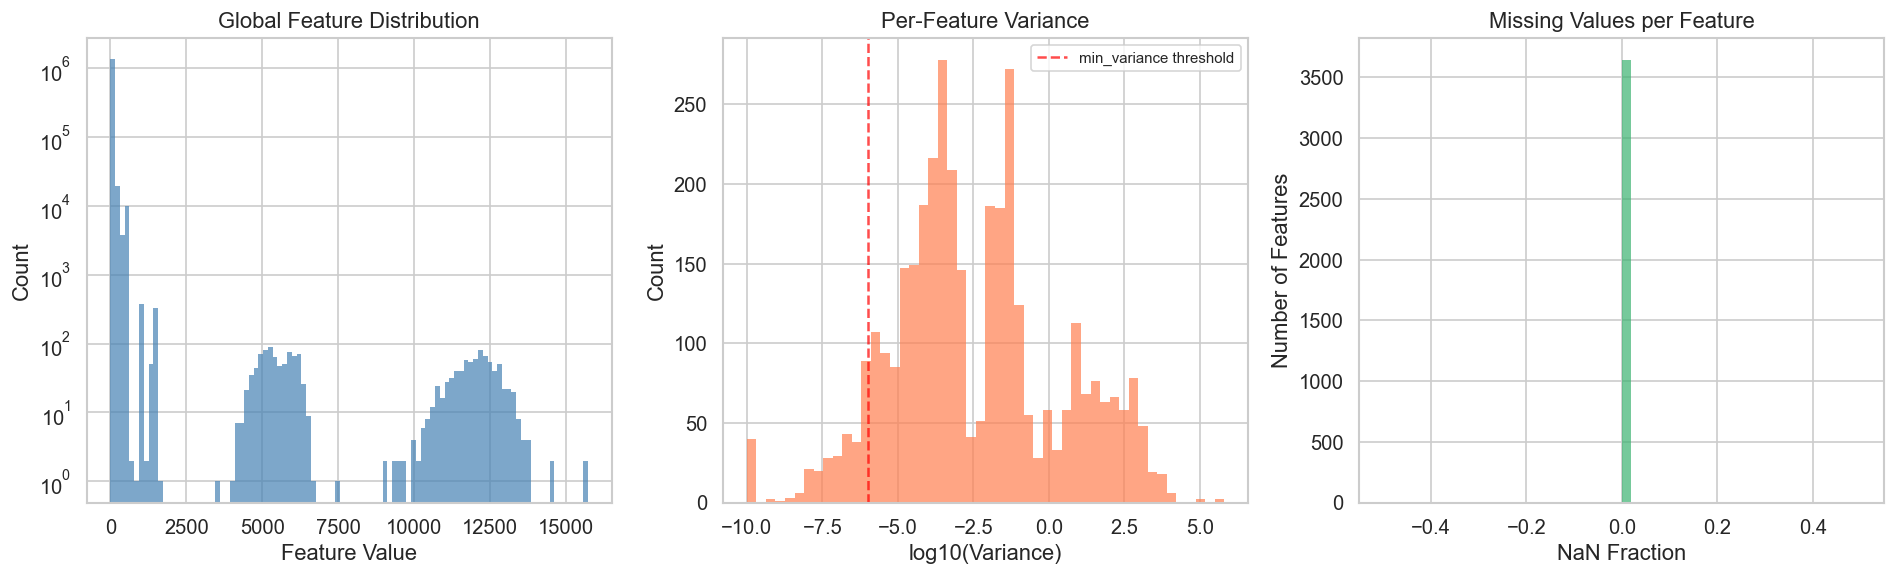


Feature matrix shape: (384, 3646)
NaN fraction (total): 0.0000
Variance range: [0.00e+00, 6.48e+05]
Features with zero variance: 40


In [15]:
# Feature value distribution (first plate)
if sample_plate_df is not None and len(feature_cols) > 0:
    feature_matrix = sample_plate_df[feature_cols].values.astype(np.float32)
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Global distribution
    flat = feature_matrix.flatten()
    flat = flat[~np.isnan(flat)]
    axes[0].hist(flat, bins=100, alpha=0.7, color="steelblue", edgecolor="none")
    axes[0].set_xlabel("Feature Value")
    axes[0].set_ylabel("Count")
    axes[0].set_title("Global Feature Distribution")
    axes[0].set_yscale("log")
    
    # Per-feature variance
    variances = np.nanvar(feature_matrix, axis=0)
    axes[1].hist(np.log10(variances + 1e-10), bins=50, alpha=0.7, color="coral", edgecolor="none")
    axes[1].set_xlabel("log10(Variance)")
    axes[1].set_ylabel("Count")
    axes[1].set_title("Per-Feature Variance")
    axes[1].axvline(x=np.log10(1e-6), color="red", linestyle="--", alpha=0.7, label="min_variance threshold")
    axes[1].legend(fontsize=9)
    
    # NaN fraction
    nan_frac = np.isnan(feature_matrix).mean(axis=0)
    axes[2].hist(nan_frac, bins=50, alpha=0.7, color="mediumseagreen", edgecolor="none")
    axes[2].set_xlabel("NaN Fraction")
    axes[2].set_ylabel("Number of Features")
    axes[2].set_title("Missing Values per Feature")
    
    plt.tight_layout()
    plt.savefig("../outputs/jumpcp_feature_distributions.png", bbox_inches="tight")
    plt.show()
    
    print(f"\nFeature matrix shape: {feature_matrix.shape}")
    print(f"NaN fraction (total): {np.isnan(feature_matrix).mean():.4f}")
    print(f"Variance range: [{variances.min():.2e}, {variances.max():.2e}]")
    print(f"Features with zero variance: {(variances < 1e-10).sum()}")

---
## 4. Quality Control

We apply well-level QC to remove low-quality wells before downstream
analysis. Criteria include NaN fraction and cell count.

In [16]:
if sample_plate_df is not None:
    qc = QualityController(max_nan_fraction=0.05, min_cell_count=50)
    qc_mask = qc.flag_wells(sample_plate_df, feature_cols)
    
    n_total = len(sample_plate_df)
    n_passed = qc_mask.sum()
    n_failed = n_total - n_passed
    
    print(f"Quality Control Results:")
    print(f"  Total wells:   {n_total}")
    print(f"  Passed:        {n_passed} ({100 * n_passed / n_total:.1f}%)")
    print(f"  Failed:        {n_failed} ({100 * n_failed / n_total:.1f}%)")

2026-02-15 23:23:12 | INFO     | protophen.data.jumpcp.curation:flag_wells:186 | QC: 377/384 wells passed all checks


Quality Control Results:
  Total wells:   384
  Passed:        377 (98.2%)
  Failed:        7 (1.8%)


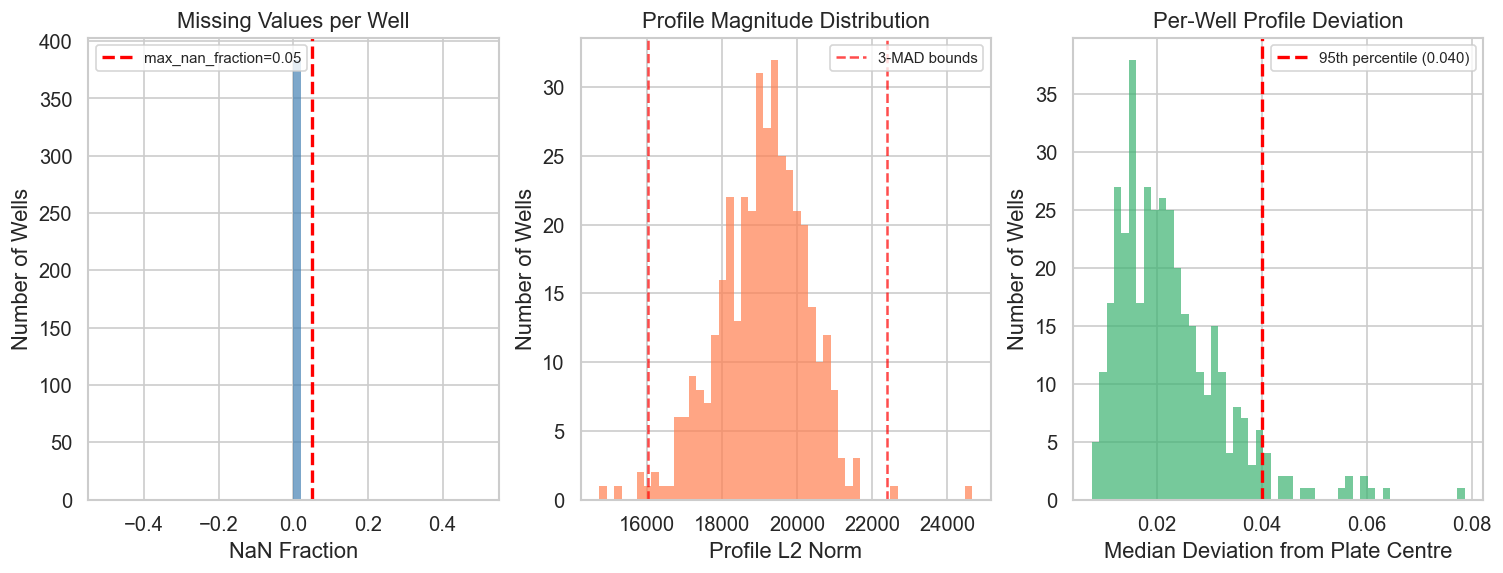

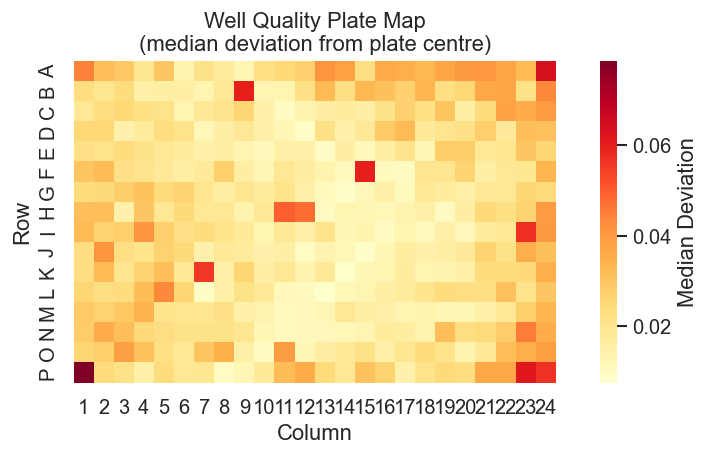

  Plate layout: 16 rows × 24 cols
  Top-left:     A01
  Bottom-right: P24


<Figure size 1200x720 with 0 Axes>

QC Summary (384 wells):
  NaN fraction:  mean=0.0000, max=0.0000, wells >5% NaN: 0
  Profile norms: median=19221.7, MAD=1060.3, outliers (3-MAD): 7
  Well deviation: mean=0.022, max=0.079
  Cell counts:   not available in aggregated profiles
                 (JUMP-CP pre-aggregated profiles omit cell counts;
                  QC relies on NaN fraction and profile outlier detection)
Plate well coverage:
  Row range:    A → P
  Column range: 1 → 24
  Total wells:  384
  Expected 1536-well: 32 rows (A–AF) × 48 cols (1–48) = 1536
  Actual:             16 rows × 24 cols = 384

  Missing columns: [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
  Missing rows:    ['Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'AA', 'AB', 'AC', 'AD', 'AE', 'AF']

  → This is expected: JUMP-CP plates leave edge wells empty
     as controls/buffer against edge effects.


In [17]:
# Visualise QC results
if sample_plate_df is not None:
    feature_cols_qc = loader.feature_columns or identify_feature_columns(sample_plate_df)
    feature_matrix_qc = sample_plate_df[feature_cols_qc].values.astype(np.float32)
    
    # --- Compute per-well quality metrics ---
    # NaN fraction per well
    nan_frac_per_well = np.isnan(feature_matrix_qc).mean(axis=1)
    
    # Profile L2 norm (unusually low/high norms indicate problematic wells)
    clean_matrix = np.nan_to_num(feature_matrix_qc, nan=0.0)
    profile_norms = np.linalg.norm(clean_matrix, axis=1)
    
    # Median absolute deviation from plate median (outlier detection)
    plate_median = np.nanmedian(feature_matrix_qc, axis=0)
    deviations = np.nanmedian(np.abs(feature_matrix_qc - plate_median), axis=1)
    
    # --- Check for cell count column (may exist in some plates) ---
    cell_count_col = None
    for c in sample_plate_df.columns:
        cl = c.lower()
        if cl.startswith("metadata_"):
            has_count = ("count" in cl or "number" in cl)
            has_object = ("cell" in cl or "nuclei" in cl or "object" in cl)
            if has_count and has_object and pd.api.types.is_numeric_dtype(sample_plate_df[c]):
                cell_count_col = c
                break
    
    has_cell_counts = cell_count_col is not None
    n_plot_cols = 3 if not has_cell_counts else 4
    
    fig, axes = plt.subplots(1, n_plot_cols, figsize=(5 * n_plot_cols, 5))
    
    # Panel 1: NaN fraction per well
    axes[0].hist(nan_frac_per_well, bins=50, alpha=0.7, color="steelblue", edgecolor="none")
    axes[0].axvline(x=0.05, color="red", linestyle="--", linewidth=2, label="max_nan_fraction=0.05")
    axes[0].set_xlabel("NaN Fraction")
    axes[0].set_ylabel("Number of Wells")
    axes[0].set_title("Missing Values per Well")
    axes[0].legend(fontsize=9)
    
    # Panel 2: Profile norms
    axes[1].hist(profile_norms, bins=50, alpha=0.7, color="coral", edgecolor="none")
    # Flag extreme norms (beyond 3 MAD from median)
    norm_median = np.median(profile_norms)
    norm_mad = np.median(np.abs(profile_norms - norm_median)) * 1.4826
    norm_lo = norm_median - 3 * norm_mad
    norm_hi = norm_median + 3 * norm_mad
    axes[1].axvline(x=norm_lo, color="red", linestyle="--", alpha=0.7, label=f"3-MAD bounds")
    axes[1].axvline(x=norm_hi, color="red", linestyle="--", alpha=0.7)
    axes[1].set_xlabel("Profile L2 Norm")
    axes[1].set_ylabel("Number of Wells")
    axes[1].set_title("Profile Magnitude Distribution")
    axes[1].legend(fontsize=9)
    
    n_norm_outliers = ((profile_norms < norm_lo) | (profile_norms > norm_hi)).sum()
    
    # Panel 3: Plate heatmap of profile deviation
    well_col = None
    for c in ["Metadata_Well", "Metadata_well"]:
        if c in sample_plate_df.columns:
            well_col = c
            break
    
    if well_col is not None:
        # Parse well positions (handles A01, AA02, B12, etc.)
        well_data = sample_plate_df[[well_col]].copy()
        well_data["deviation"] = deviations
        well_data["row"] = well_data[well_col].str.extract(r'^([A-Za-z]+)', expand=False)
        well_data["col"] = well_data[well_col].str.extract(r'(\d+)$', expand=False).astype(int)

        # Enforce standard plate ordering (A→AF top→bottom, 1→48 left→right)
        unique_rows = well_data["row"].unique()
        row_order = sorted(unique_rows, key=lambda r: (len(r), r))
        unique_cols = sorted(well_data["col"].unique())

        pivot = well_data.pivot_table(
            index="row", columns="col", values="deviation", aggfunc="first"
        )
        pivot = pivot.reindex(index=row_order, columns=unique_cols)

        # --- Panel 3: Deviation histogram (readable at subplot scale) ---
        axes[2].hist(deviations, bins=50, alpha=0.7, color="mediumseagreen", edgecolor="none")
        # Mark the 95th percentile as a high-deviation threshold
        p95 = np.percentile(deviations, 95)
        axes[2].axvline(x=p95, color="red", linestyle="--", linewidth=2,
                        label=f"95th percentile ({p95:.3f})")
        axes[2].set_xlabel("Median Deviation from Plate Centre")
        axes[2].set_ylabel("Number of Wells")
        axes[2].set_title("Per-Well Profile Deviation")
        axes[2].legend(fontsize=9)

        # --- Standalone plate heatmap (full spatial detail) ---
        fig_plate, ax_plate = plt.subplots(
            figsize=(max(8, len(unique_cols) * 0.25), max(4, len(row_order) * 0.25))
        )
        sns.heatmap(
            pivot,
            ax=ax_plate,
            cmap="YlOrRd",
            annot=False,
            cbar_kws={"label": "Median Deviation"},
            xticklabels=True,
            yticklabels=True,
        )
        ax_plate.set_title("Well Quality Plate Map\n(median deviation from plate centre)")
        ax_plate.set_xlabel("Column")
        ax_plate.set_ylabel("Row")
        ax_plate.set_aspect("equal")
        fig_plate.tight_layout()
        fig_plate.savefig("../outputs/jumpcp_plate_map.png", bbox_inches="tight")
        plt.show()

        # Verify A1 is top-left
        print(f"  Plate layout: {len(row_order)} rows × {len(unique_cols)} cols")
        print(f"  Top-left:     {row_order[0]}{unique_cols[0]:02d}")
        print(f"  Bottom-right: {row_order[-1]}{unique_cols[-1]:02d}")

    else:
        axes[2].hist(deviations, bins=50, alpha=0.7, color="mediumseagreen", edgecolor="none")
        axes[2].set_xlabel("Median Deviation")
        axes[2].set_ylabel("Number of Wells")
        axes[2].set_title("Per-Well Deviation from Plate Median")
    
    # Panel 4: Cell counts (if available)
    if has_cell_counts:
        cell_counts = sample_plate_df[cell_count_col].dropna().astype(int)
        axes[3].hist(cell_counts, bins=50, alpha=0.7, color="mediumpurple", edgecolor="none")
        axes[3].axvline(x=50, color="red", linestyle="--", linewidth=2, label="min_cell_count=50")
        axes[3].set_xlabel("Cell Count")
        axes[3].set_ylabel("Number of Wells")
        axes[3].set_title(f"Cell Count Distribution\n({cell_count_col})")
        axes[3].legend(fontsize=9)
    
    plt.tight_layout()
    plt.savefig("../outputs/jumpcp_qc_overview.png", bbox_inches="tight")
    plt.show()
    
    # --- Summary statistics ---
    print(f"QC Summary ({len(sample_plate_df)} wells):")
    print(f"  NaN fraction:  mean={nan_frac_per_well.mean():.4f}, "
          f"max={nan_frac_per_well.max():.4f}, "
          f"wells >5% NaN: {(nan_frac_per_well > 0.05).sum()}")
    print(f"  Profile norms: median={norm_median:.1f}, MAD={norm_mad:.1f}, "
          f"outliers (3-MAD): {n_norm_outliers}")
    print(f"  Well deviation: mean={deviations.mean():.3f}, "
          f"max={deviations.max():.3f}")
    
    if has_cell_counts:
        print(f"  Cell counts:   mean={cell_counts.mean():.0f}, "
              f"median={cell_counts.median():.0f}, "
              f"wells <50: {(cell_counts < 50).sum()}")
    else:
        print(f"  Cell counts:   not available in aggregated profiles")
        print(f"                 (JUMP-CP pre-aggregated profiles omit cell counts;")
        print(f"                  QC relies on NaN fraction and profile outlier detection)")
        
# Plate layout analysis
if sample_plate_df is not None and well_col is not None:
    wells = sample_plate_df[well_col]
    rows = wells.str.extract(r'^([A-Za-z]+)', expand=False)
    cols = wells.str.extract(r'(\d+)$', expand=False).astype(int)
    
    print(f"Plate well coverage:")
    print(f"  Row range:    {sorted(rows.unique(), key=lambda r: (len(r), r))[0]} → "
          f"{sorted(rows.unique(), key=lambda r: (len(r), r))[-1]}")
    print(f"  Column range: {cols.min()} → {cols.max()}")
    print(f"  Total wells:  {len(wells)}")
    print(f"  Expected 1536-well: 32 rows (A–AF) × 48 cols (1–48) = 1536")
    print(f"  Actual:             {rows.nunique()} rows × {cols.nunique()} cols = {len(wells)}")
    
    # Check for missing edge wells
    all_cols = set(range(1, 49))
    present_cols = set(cols.unique())
    missing_cols = sorted(all_cols - present_cols)
    
    all_rows_expected = (
        [chr(65 + i) for i in range(26)] +
        [f"A{chr(65 + i)}" for i in range(6)]
    )
    present_rows = set(rows.unique())
    missing_rows = [r for r in all_rows_expected if r not in present_rows]
    
    if missing_cols or missing_rows:
        print(f"\n  Missing columns: {missing_cols if missing_cols else 'none'}")
        print(f"  Missing rows:    {missing_rows if missing_rows else 'none'}")
        print(f"\n  → This is expected: JUMP-CP plates leave edge wells empty")
        print(f"     as controls/buffer against edge effects.")
    else:
        print(f"\n  All 1536 positions occupied.")

In [18]:
# Cell count detection: testing with synthetic data
    ## JUMP-CP pre-aggregated profiles don't include cell counts. 
    ## However, our QC pipeline will encounter them in our ProToPhen experimental data. 
    ## Verify the detection works:

from protophen.data.jumpcp.curation import QualityController

# Simulate a CellProfiler-style output with cell counts
synthetic_df = pd.DataFrame({
    "Metadata_Plate": ["P1"] * 10,
    "Metadata_Well": [f"A{i:02d}" for i in range(1, 11)],
    "Metadata_Count_Cells": [200, 150, 30, 180, 10, 250, 45, 300, 5, 175],
    "Cells_Intensity_Mean": np.random.randn(10),
    "Cells_AreaShape_Area": np.random.randn(10),
    "Nuclei_Texture_Contrast": np.random.randn(10),
})

qc = QualityController(min_cell_count=50, max_nan_fraction=0.1)
features = ["Cells_Intensity_Mean", "Cells_AreaShape_Area", "Nuclei_Texture_Contrast"]
mask = qc.flag_wells(synthetic_df, features)

print("Cell count QC test (min_cell_count=50):")
for i, (_, row) in enumerate(synthetic_df.iterrows()):
    status = "PASS" if mask.iloc[i] else "FAIL"
    print(f"  Well {row['Metadata_Well']}: {int(row['Metadata_Count_Cells']):3d} cells → {status}")

n_expected_fail = (synthetic_df["Metadata_Count_Cells"] < 50).sum()
n_actual_fail = (~mask).sum()
print(f"\nExpected failures: {n_expected_fail}, Actual: {n_actual_fail}")
assert n_actual_fail >= n_expected_fail, "Cell count QC is not catching low-count wells!"
print("Cell count detection working correctly!")

2026-02-15 23:23:13 | INFO     | protophen.data.jumpcp.curation:flag_wells:186 | QC: 6/10 wells passed all checks


Cell count QC test (min_cell_count=50):
  Well A01: 200 cells → PASS
  Well A02: 150 cells → PASS
  Well A03:  30 cells → FAIL
  Well A04: 180 cells → PASS
  Well A05:  10 cells → FAIL
  Well A06: 250 cells → PASS
  Well A07:  45 cells → FAIL
  Well A08: 300 cells → PASS
  Well A09:   5 cells → FAIL
  Well A10: 175 cells → PASS

Expected failures: 4, Actual: 4
Cell count detection working correctly!


---
## 5. Feature Selection & Normalisation

Cell Painting features require careful preprocessing:
1. **Feature selection** — remove low-variance, highly-correlated, and high-NaN features.
2. **Normalisation** — robust MAD normalisation to handle outliers.
3. **Batch correction** — align distributions across plates.

In [19]:
if sample_plate_df is not None:
    # Apply feature selection
    feature_matrix = sample_plate_df[feature_cols].values.astype(np.float32)
    feature_matrix = np.nan_to_num(feature_matrix, nan=0.0)
    
    selector = FeatureSelector(
        min_variance=1e-6,
        max_correlation=0.95,
        max_nan_fraction=0.05,
    )
    selected_matrix = selector.fit_transform(feature_matrix)
    selected_names = [feature_cols[i] for i in selector.selected_indices_]
    
    print(f"Feature Selection:")
    print(f"  Input features:    {len(feature_cols)}")
    print(f"  Selected features: {selector.n_selected_}")
    print(f"  Removed features:  {selector.n_removed_}")
    
    # Removal summary
    removal_summary = selector.get_removal_summary()
    if len(removal_summary) > 0:
        reason_counts = removal_summary["reason"].apply(
            lambda r: r.split("=")[0] if "=" in r else r
        ).value_counts()
        print(f"\n  Removal reasons:")
        for reason, count in reason_counts.items():
            print(f"    {reason}: {count}")

2026-02-15 23:23:19 | INFO     | protophen.phenotype.normalisation:fit:566 | Selected 837 of 3646 features


Feature Selection:
  Input features:    3646
  Selected features: 837
  Removed features:  2809

  Removal reasons:
    high_correlation: 2524
    low_variance: 285


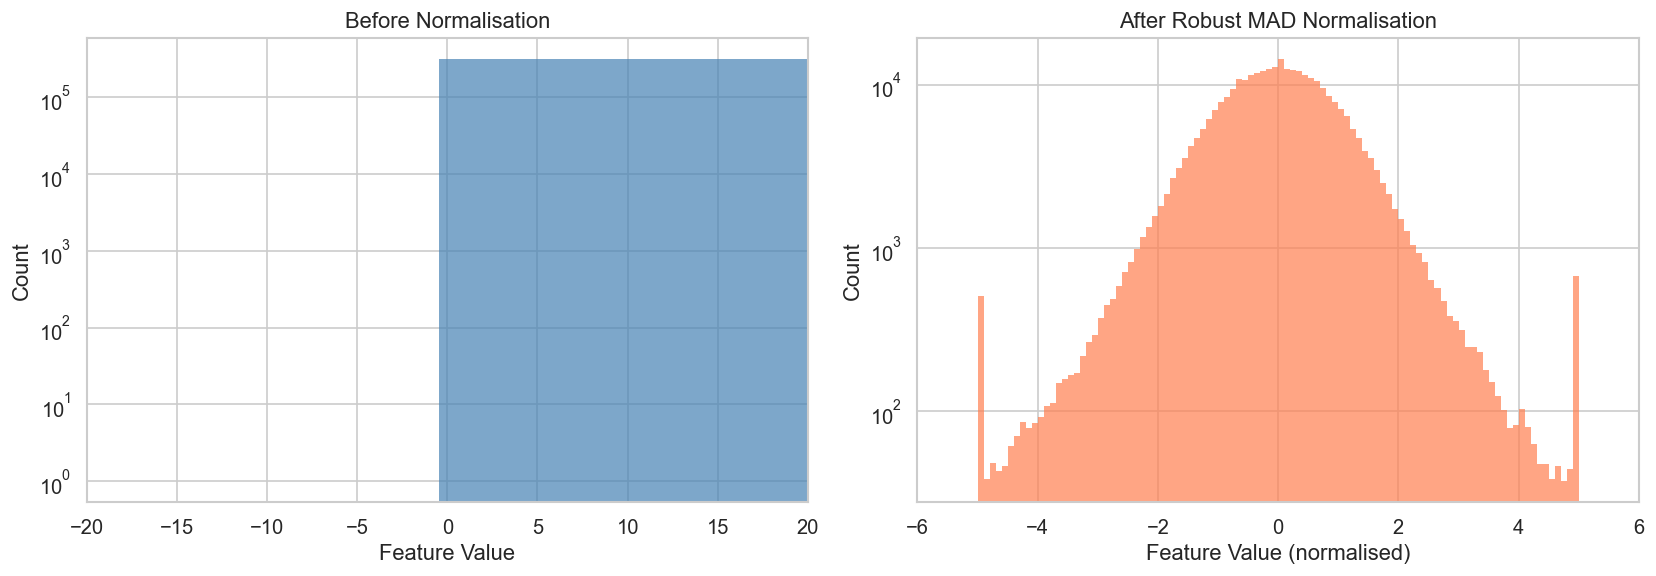


Before: mean=29.462, std=466.390
After:  mean=-0.003, std=1.124


In [20]:
if sample_plate_df is not None:
    # Apply normalisation
    normaliser = Normaliser(method="robust_mad", clip_outliers=True, outlier_threshold=5.0)
    normalised_matrix = normaliser.fit_transform(selected_matrix)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Before normalisation
    flat_before = selected_matrix.flatten()
    axes[0].hist(flat_before, bins=100, alpha=0.7, color="steelblue", edgecolor="none")
    axes[0].set_xlabel("Feature Value")
    axes[0].set_ylabel("Count")
    axes[0].set_title("Before Normalisation")
    axes[0].set_yscale("log")
    axes[0].set_xlim(-20, 20)
    
    # After normalisation
    flat_after = normalised_matrix.flatten()
    axes[1].hist(flat_after, bins=100, alpha=0.7, color="coral", edgecolor="none")
    axes[1].set_xlabel("Feature Value (normalised)")
    axes[1].set_ylabel("Count")
    axes[1].set_title("After Robust MAD Normalisation")
    axes[1].set_yscale("log")
    axes[1].set_xlim(-6, 6)
    
    plt.tight_layout()
    plt.savefig("../outputs/jumpcp_normalisation.png", bbox_inches="tight")
    plt.show()
    
    print(f"\nBefore: mean={flat_before.mean():.3f}, std={flat_before.std():.3f}")
    print(f"After:  mean={flat_after.mean():.3f}, std={flat_after.std():.3f}")

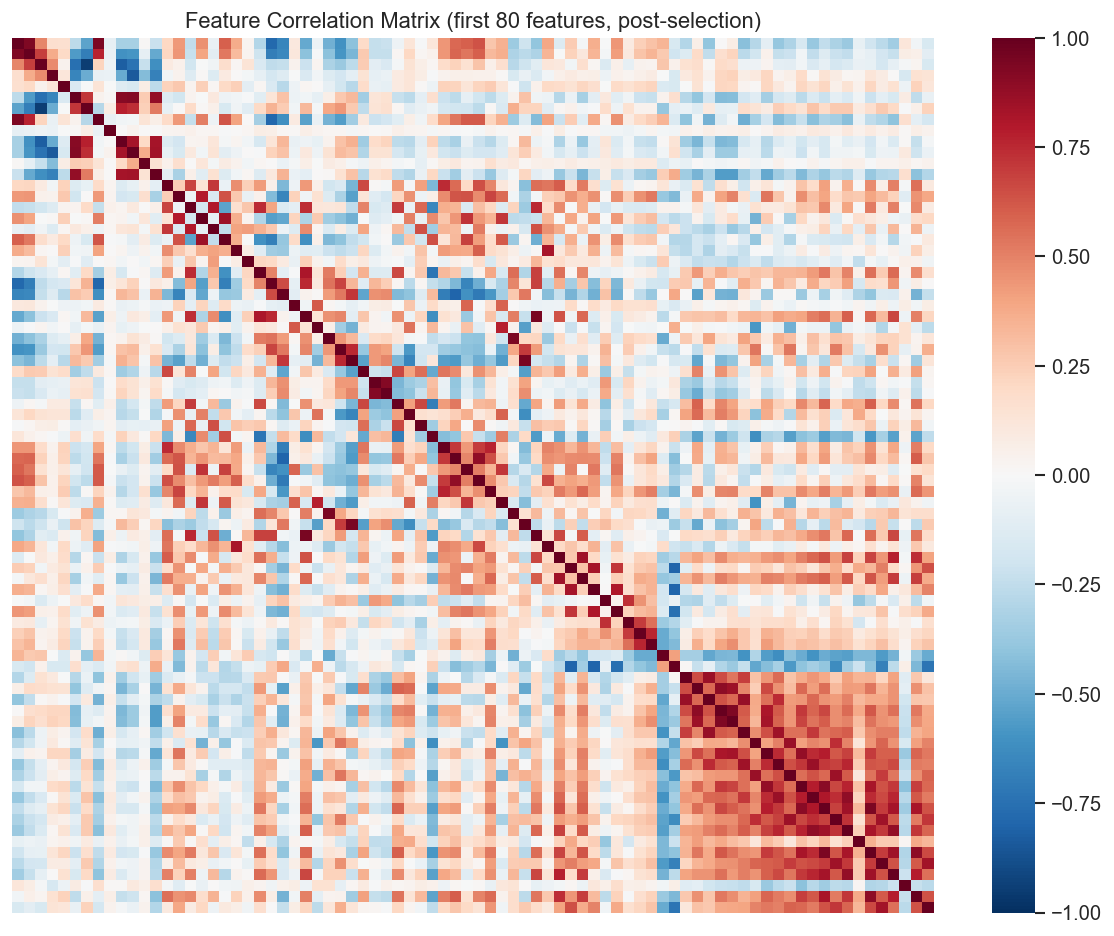

In [21]:
# Feature correlation structure
if sample_plate_df is not None and selected_matrix.shape[1] > 0:
    n_show = min(80, selected_matrix.shape[1])
    corr = np.corrcoef(normalised_matrix[:, :n_show].T)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        corr,
        ax=ax,
        cmap="RdBu_r",
        center=0,
        vmin=-1,
        vmax=1,
        xticklabels=False,
        yticklabels=False,
    )
    ax.set_title(f"Feature Correlation Matrix (first {n_show} features, post-selection)")
    plt.tight_layout()
    plt.savefig("../outputs/jumpcp_correlation_matrix.png", bbox_inches="tight")
    plt.show()

---
## 6. Pre-training Data Curation

The `DataCurator` class orchestrates the full curation pipeline:
metadata → profile loading → QC → feature selection → normalisation →
batch correction → aggregation → (optional) gene sampling.

Here we run a **small-scale test** with a limited number of plates.

In [22]:
# Check available plate types before curation
if plate_df is not None:
    plate_type_col = None
    for c in plate_df.columns:
        cl = c.lower()
        if "platetype" in cl or ("pert" in cl and "type" in cl):
            plate_type_col = c
            break
        
    if plate_type_col:
        print(f"Plate type (column: {plate_type_col}):")
        type_counts = plate_df[plate_type_col].value_counts()
        for ptype, count in type_counts.items():
            print(f"  {ptype:25s} {count:5d} plates")
    else:
        print("No plate type column found.")

Plate type (column: Metadata_PlateType):
  COMPOUND                   1876 plates
  ORF                         251 plates
  CRISPR                      148 plates
  TARGET2                     141 plates
  DMSO                         77 plates
  COMPOUND_EMPTY               20 plates
  POSCON8                       8 plates
  TARGET1                       4 plates


In [23]:
# Configure a small curation run
    ## Note: We are using min_replicates=1 for small test runs because with only a small set of plates, most genes appear only once. For full runs, min_replicates=2 or 3 is more appropriate.
    
N_PLATES_DEMO = 10  # Increase for more meaningful results (e.g., 251 for all ORF plates)

curation_config = CurationConfig(
    perturbation_types=["orf"],
    max_plates=N_PLATES_DEMO,                  # Small test - increase for real runs
    min_replicates=1,                          # Set to 1 for demo - 2+ for production runs
    min_cell_count=50,
    normalisation_method="robust_mad",
    batch_correction=True,
    batch_correction_method="robust",
    aggregation_method="median",
    sampling_strategy="all",                   # No subsampling for now
    output_name="pretraining_test",
)

print("Curation configuration:")
print(f"  Perturbation types: {curation_config.perturbation_types}")
print(f"  Max plates:         {N_PLATES_DEMO}")
print(f"  Min replicates:     {curation_config.min_replicates}")
print(f"  Normalisation:      {curation_config.normalisation_method}")
print(f"  Aggregation:        {curation_config.aggregation_method}")
print(f"  Batch correction:   {curation_config.batch_correction} ({curation_config.batch_correction_method})")

Curation configuration:
  Perturbation types: ['orf']
  Max plates:         10
  Min replicates:     1
  Normalisation:      robust_mad
  Aggregation:        median
  Batch correction:   True (robust)


In [24]:
# Run curation (requires network access)
curated_df = None

if HAS_S3:
    print("\nRunning curation pipeline...")
    print("=" * 60)
    
    try:
        curator = DataCurator(
            config=curation_config,
            jumpcp_config=config,
        )
        curated_df = curator.build_pretraining_set()
        
        print("\n" + "=" * 60)
        print("Curation complete!")
        curator.print_report()
        
        # Additional diagnostics
        gene_col = DataCurator._detect_gene_column(curated_df)
        if gene_col is not None:
            print(f"\nGene column: {gene_col}")
            print(f"Unique genes: {curated_df[gene_col].nunique()}")
            print(f"Sample genes: {curated_df[gene_col].dropna().unique()[:10].tolist()}")
            n_null = curated_df[gene_col].isna().sum()
            if n_null > 0:
                print(f"Warning: {n_null} treatments have no gene annotation.")
        else:
            print(f"Warning: No gene column detected in curated output.")
            print(f"    Columns: {[c for c in curated_df.columns if c.startswith('Metadata_')]}")
    except Exception as e:
        print(f"\nCuration failed: {e}")
        print("  This typically requires S3 access and sufficient plate data.")
        import traceback
        traceback.print_exc()
elif HAS_HTTPS:
    print("S3 not available — attempting with HTTPS-only metadata download.")
    print("Profile loading requires S3 or pre-cached data.")
    print("Run `scripts/download_jumpcp.py --profiles` first.")
else:
    print("No network available — skipping curation.")
    print("To run offline, first cache data with `scripts/download_jumpcp.py`.")

2026-02-15 23:23:20 | INFO     | protophen.data.jumpcp.access:__init__:167 | Initialised JUMPCPAccess
2026-02-15 23:23:20 | INFO     | protophen.data.jumpcp.curation:build_pretraining_set:262 | Step 1: Resolving plates from metadata
2026-02-15 23:23:20 | INFO     | protophen.data.jumpcp.metadata:get_plates_for_perturbation:273 | Found 251 plates for perturbation type 'orf'
2026-02-15 23:23:20 | INFO     | protophen.data.jumpcp.metadata:get_plate_batch_source_map:372 | Plate→source/batch mapping: 251 entries (orf)
2026-02-15 23:23:20 | INFO     | protophen.data.jumpcp.curation:build_pretraining_set:272 | Total plates available: 251
2026-02-15 23:23:20 | INFO     | protophen.data.jumpcp.curation:build_pretraining_set:277 | Step 2: Loading well-level profiles



Running curation pipeline...


2026-02-15 23:23:21 | INFO     | protophen.data.jumpcp.profiles:load_plate_profiles:151 | Plate 'BR00117035': 384 wells, 3646 features
2026-02-15 23:23:21 | INFO     | protophen.data.jumpcp.access:fetch_plate_profiles:526 | Fetching profiles for plate 'BR00117036' from S3
2026-02-15 23:23:27 | INFO     | protophen.data.jumpcp.profiles:load_plate_profiles:151 | Plate 'BR00117036': 384 wells, 3646 features
2026-02-15 23:23:27 | INFO     | protophen.data.jumpcp.access:fetch_plate_profiles:526 | Fetching profiles for plate 'BR00117037' from S3
2026-02-15 23:23:35 | INFO     | protophen.data.jumpcp.profiles:load_plate_profiles:151 | Plate 'BR00117037': 384 wells, 3646 features
2026-02-15 23:23:35 | INFO     | protophen.data.jumpcp.access:fetch_plate_profiles:526 | Fetching profiles for plate 'BR00117038' from S3
2026-02-15 23:23:42 | INFO     | protophen.data.jumpcp.profiles:load_plate_profiles:151 | Plate 'BR00117038': 384 wells, 3646 features
2026-02-15 23:23:42 | INFO     | protophen.dat


Curation complete!


           JUMP-CP Curation Report            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Metric                   ┃ Value           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ n_plates_available       │ 251             │
│ n_wells_raw              │ 3840            │
│ n_features_raw           │ 3646            │
│ n_wells_after_merge      │ 3840            │
│ gene_column              │ Metadata_Symbol │
│ n_genes_merged           │ 913             │
│ n_wells_post_qc          │ 3743            │
│ n_features_selected      │ 757             │
│ batch_correction_applied │ True            │
│ n_batches                │ 10              │
│ n_treatments_aggregated  │ 1004            │
│ n_treatments_final       │ 1004            │
│ n_features_final         │ 757             │
└──────────────────────────┴─────────────────┘


Gene column: Metadata_JCP2022
Unique genes: 1004
Sample genes: ['JCP2022_900001', 'JCP2022_900008', 'JCP2022_900034', 'JCP2022_900162', 'JCP2022_900167', 'JCP2022_900214', 'JCP2022_900218', 'JCP2022_900220', 'JCP2022_900257', 'JCP2022_900258']


In [25]:
# Inspect curated output
if curated_df is not None:
    print(f"Curated dataset: {curated_df.shape[0]} treatments × {curated_df.shape[1]} columns")
    
    meta_cols_curated = [c for c in curated_df.columns if c.startswith("Metadata_") or c.startswith("_")]
    feat_cols_curated = [c for c in curated_df.columns if c not in meta_cols_curated]
    
    print(f"  Metadata columns: {len(meta_cols_curated)}")
    print(f"  Feature columns:  {len(feat_cols_curated)}")
    
    if meta_cols_curated:
        print(f"\n  Metadata preview:")
        print(curated_df[meta_cols_curated].head().to_string(index=False))

Curated dataset: 1004 treatments × 759 columns
  Metadata columns: 2
  Feature columns:  757

  Metadata preview:
Metadata_JCP2022  _n_replicates
  JCP2022_900001             37
  JCP2022_900008              5
  JCP2022_900034              5
  JCP2022_900162              3
  JCP2022_900167              3


In [26]:
# Save curated dataset
if curated_df is not None:
    output_dir = Path("../data/processed/pretraining")
    paths = curator.save(curated_df, output_dir)
    
    print(f"\nSaved artefacts:")
    for name, path in paths.items():
        size_mb = path.stat().st_size / 1e6
        print(f"  {name}: {path} ({size_mb:.1f} MB)")

2026-02-15 23:25:11 | INFO     | protophen.data.jumpcp.curation:save:829 | Saved profiles to ..\data\processed\pretraining\pretraining_test.parquet
2026-02-15 23:25:11 | INFO     | protophen.data.jumpcp.cache:store_curated_dataset:251 | Stored curated dataset 'pretraining_test' (1004 rows)
2026-02-15 23:25:11 | INFO     | protophen.data.jumpcp.curation:save:853 | Curation artefacts saved to ..\data\processed\pretraining



Saved artefacts:
  profiles: ..\data\processed\pretraining\pretraining_test.parquet (4.5 MB)
  report: ..\data\processed\pretraining\pretraining_test_report.json (0.0 MB)
  features: ..\data\processed\pretraining\pretraining_test_features.json (0.0 MB)


c:\Users\adou0002\protophen\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


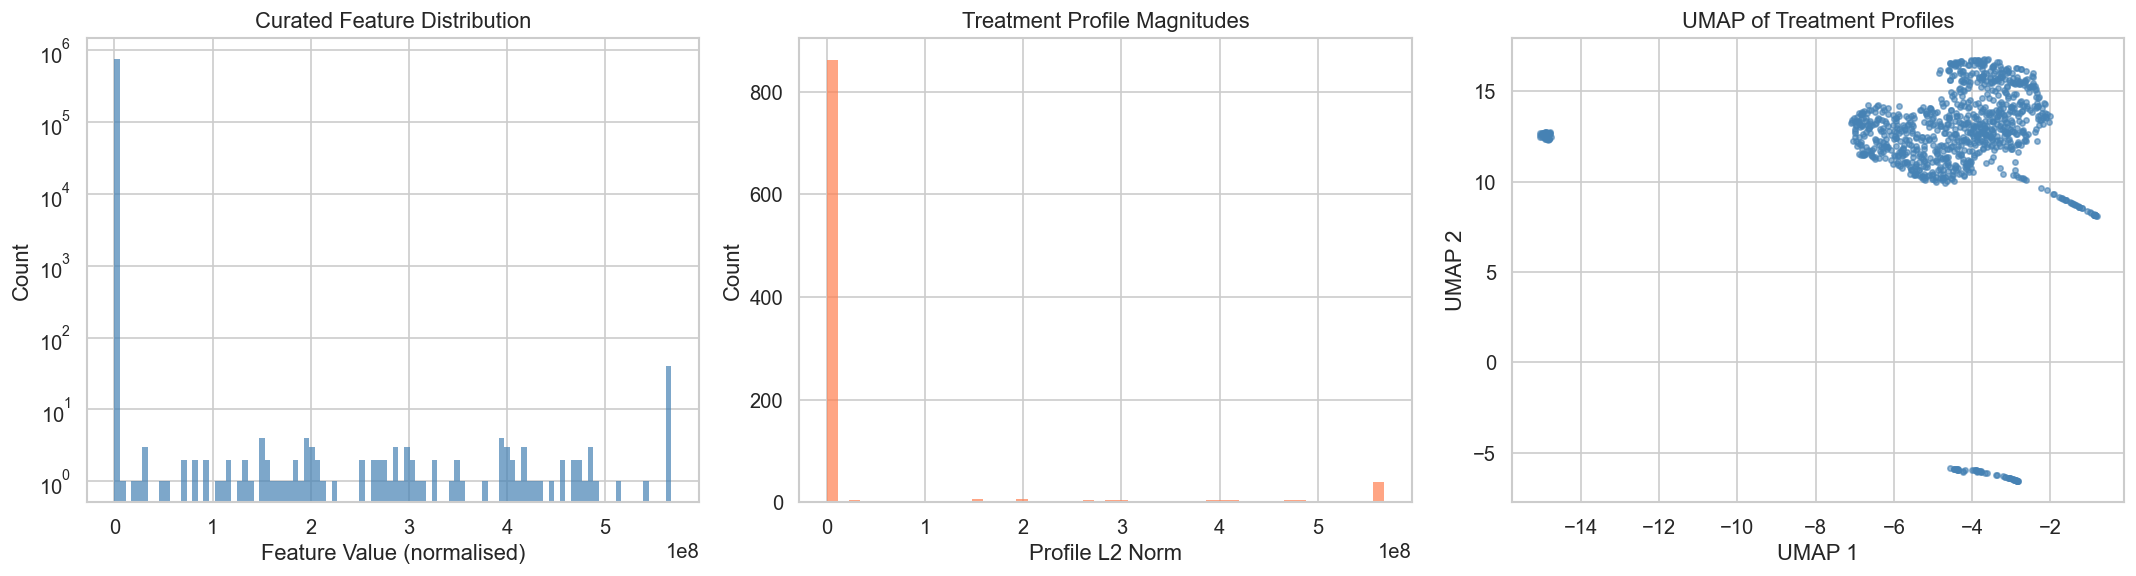

In [27]:
# Visualise curated feature space
if curated_df is not None and len(feat_cols_curated) > 0:
    curated_features = curated_df[feat_cols_curated].values.astype(np.float32)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Feature distribution
    flat = curated_features.flatten()
    axes[0].hist(flat, bins=100, alpha=0.7, color="steelblue", edgecolor="none")
    axes[0].set_xlabel("Feature Value (normalised)")
    axes[0].set_ylabel("Count")
    axes[0].set_title("Curated Feature Distribution")
    axes[0].set_yscale("log")
    
    # Per-treatment profile norms
    norms = np.linalg.norm(curated_features, axis=1)
    axes[1].hist(norms, bins=50, alpha=0.7, color="coral", edgecolor="none")
    axes[1].set_xlabel("Profile L2 Norm")
    axes[1].set_ylabel("Count")
    axes[1].set_title("Treatment Profile Magnitudes")
    
    # UMAP embedding (if enough samples)
    if curated_features.shape[0] >= 15:
        try:
            from umap import UMAP
            
            reducer = UMAP(n_components=2, random_state=42, n_neighbors=min(15, len(curated_features) - 1))
            embedding = reducer.fit_transform(curated_features)
            
            axes[2].scatter(
                embedding[:, 0], embedding[:, 1],
                s=10, alpha=0.6, color="steelblue",
            )
            axes[2].set_xlabel("UMAP 1")
            axes[2].set_ylabel("UMAP 2")
            axes[2].set_title("UMAP of Treatment Profiles")
        except ImportError:
            axes[2].text(0.5, 0.5, "umap-learn not installed",
                        ha="center", va="center", transform=axes[2].transAxes)
            axes[2].set_title("UMAP (unavailable)")
    else:
        axes[2].text(0.5, 0.5, f"Too few samples ({curated_features.shape[0]})\nfor UMAP",
                    ha="center", va="center", transform=axes[2].transAxes)
        axes[2].set_title("UMAP (insufficient data)")
    
    plt.tight_layout()
    plt.savefig("../outputs/jumpcp_curated_overview.png", bbox_inches="tight")
    plt.show()

---
## 7. Bridge to ProToPhen Data Structures

The curated JUMP-CP data must be converted to ProToPhen's
`PhenotypeDataset` for downstream model training. We also demonstrate
how to reload a previously curated dataset.

In [28]:
# Convert to PhenotypeDataset
if curated_df is not None:
    dataset = curator.to_phenotype_dataset(curated_df, dataset_name="jumpcp_pretraining")
    
    print(f"PhenotypeDataset: {dataset}")
    summary = dataset.summary()
    print(f"\nSummary:")
    for key, value in summary.items():
        print(f"  {key}: {value}")

2026-02-15 23:25:23 | INFO     | protophen.data.jumpcp.profiles:to_phenotype_dataset:395 | Created PhenotypeDataset 'jumpcp_pretraining' with 1004 samples


PhenotypeDataset: PhenotypeDataset(name='jumpcp_pretraining', n_samples=1004)

Summary:
  name: jumpcp_pretraining
  n_samples: 1004
  n_features: 757
  n_plates: 0
  n_proteins: 1004
  n_qc_passed: 1004
  feature_stats: {'mean': 66017.25, 'std': 5408831.0, 'n_nan': 0}


In [29]:
# Demonstrate reloading from disk
saved_path = Path("../data/processed/pretraining/pretraining_test.parquet")

if saved_path.exists():
    loaded_df, loaded_report, loaded_features = DataCurator.load_curated(saved_path)
    
    print(f"Reloaded dataset: {loaded_df.shape[0]} treatments x {loaded_df.shape[1]} columns")
    print(f"Feature names: {len(loaded_features)} features")
    
    if loaded_report:
        print(f"\nCuration report:")
        for key, value in loaded_report.items():
            if key != "config":
                print(f"  {key}: {value}")
else:
    print(f"No saved dataset found at {saved_path}")
    print("Run the curation cell above first, or use scripts/curate_pretraining.py")

2026-02-15 23:25:23 | INFO     | protophen.data.jumpcp.curation:load_curated:887 | Loaded curated dataset from ..\data\processed\pretraining\pretraining_test.parquet: 1004 treatments, 757 features


Reloaded dataset: 1004 treatments x 759 columns
Feature names: 757 features

Curation report:
  n_plates_available: 251
  n_wells_raw: 3840
  n_features_raw: 3646
  n_wells_after_merge: 3840
  gene_column: Metadata_Symbol
  n_genes_merged: 913
  n_wells_post_qc: 3743
  n_features_selected: 757
  batch_correction_applied: True
  n_batches: 10
  n_treatments_aggregated: 1004
  n_treatments_final: 1004
  n_features_final: 757


In [30]:
# Show how this connects to ProtoPhenDataset (model training)
if curated_df is not None:
    from protophen.data.dataset import ProtoPhenDataset, ProtoPhenSample
    
    # In practice, you would:
    # 1. Get protein embeddings for each gene (via ESMEmbedder)
    # 2. Pair with phenotype profiles
    # 3. Create ProtoPhenDataset
    
    # Demonstration with dummy embeddings
    gene_col = DataCurator._detect_gene_column(curated_df)
    if gene_col is not None:
        n_treatments = len(curated_df)
        dummy_embed_dim = 1280  # ESM-2 650M dimension
        
        samples = []
        for idx, row in curated_df.iterrows():
            features = row[feat_cols_curated].values.astype(np.float32)
            
            sample = ProtoPhenSample(
                protein_id=str(row[gene_col]) if gene_col else f"gene_{idx}",
                protein_embedding=np.random.randn(dummy_embed_dim).astype(np.float32),
                phenotypes={"cell_painting": features},
                metadata={"source": "jumpcp"},
            )
            samples.append(sample)
        
        proto_dataset = ProtoPhenDataset(samples=samples)
        print(f"ProtoPhenDataset: {proto_dataset}")
        print(f"  Embedding dim: {proto_dataset.embedding_dim}")
        print(f"  Phenotype dims: {proto_dataset.phenotype_dims}")
        
        # Verify __getitem__ works
        sample = proto_dataset[0]
        print(f"\n  Sample keys: {[k for k in sample.keys() if k != 'metadata']}")
        print(f"  protein_embedding shape: {sample['protein_embedding'].shape}")
        if "cell_painting" in sample:
            print(f"  cell_painting shape: {sample['cell_painting'].shape}")
    else:
        print("Could not detect gene column — skipping ProtoPhenDataset demo.")

ProtoPhenDataset: ProtoPhenDataset(n_samples=1004, embedding_dim=1280, tasks=['cell_painting'])
  Embedding dim: 1280
  Phenotype dims: {'cell_painting': 757}

  Sample keys: ['protein_embedding', 'protein_id', 'cell_painting', 'mask_cell_painting']
  protein_embedding shape: torch.Size([1280])
  cell_painting shape: torch.Size([757])


---
## 8. Gene → Protein Sequence Mapping

To use JUMP-CP data for ProToPhen pre-training, we need protein sequences
for each gene. We query UniProt's REST API to map gene symbols to canonical
sequences.

In [31]:
# Fetch sequences for a small test set
if HAS_HTTPS:
    test_genes = ["TP53", "BRCA1", "EGFR", "MYC", "KRAS"]
    
    print(f"Fetching sequences for {len(test_genes)} test genes...")
    sequences = access.fetch_uniprot_sequences(test_genes)
    
    print(f"\nResolved {len(sequences)}/{len(test_genes)} genes:\n")
    for gene, seq in sequences.items():
        print(f"  {gene:8s}  length={len(seq):5d}  {seq[:40]}...")
else:
    print("No network — skipping UniProt sequence fetch.")
    print("Run `scripts/download_jumpcp.py --sequences` to pre-cache.")

2026-02-15 23:25:24 | INFO     | protophen.data.jumpcp.access:fetch_uniprot_sequences:601 | All 5 gene sequences loaded from cache


Fetching sequences for 5 test genes...

Resolved 5/5 genes:

  TP53      length=  410  MDDLMLSPDDIEQWFTEDPGPDEAPRMPEAAPPVAPAPAA...
  BRCA1     length= 1863  MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCD...
  EGFR      length= 1157  MFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIAL...
  MYC       length=  454  MDFFRVVENQQPPATMPLNVSFTNRNYDLDYDSVQPYFYC...
  KRAS      length=  189  MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSY...


In [32]:
# Demonstrate integration with ProteinLibrary
if HAS_HTTPS and len(sequences) > 0:
    from protophen.data.protein import Protein, ProteinLibrary
    
    library = ProteinLibrary(name="jumpcp_orf")
    
    for gene, seq in sequences.items():
        protein = Protein(
            sequence=seq,
            name=gene,
            source="uniprot",
            metadata={"gene_symbol": gene, "organism": "Homo sapiens"},
        )
        library.add(protein)
    
    print(f"ProteinLibrary: {library}")
    print(f"  Proteins: {len(library)}")
    for protein in library:
        print(f"    {protein.name}: {protein.length} aa, hash={protein.hash[:12]}...")
    
    print(f"\n→ Next step: extract ESM-2 embeddings with ESMEmbedder")
    print(f"→ Then pair with JUMP-CP profiles in ProtoPhenDataset")

ProteinLibrary: ProteinLibrary(name='jumpcp_orf', count=5)
  Proteins: 5
    TP53: 410 aa, hash=ab5e94b625bf...
    BRCA1: 1863 aa, hash=80d7199c8d15...
    EGFR: 1157 aa, hash=0edaea94721b...
    MYC: 454 aa, hash=655b0e233155...
    KRAS: 189 aa, hash=1d5a9ab11f64...

→ Next step: extract ESM-2 embeddings with ESMEmbedder
→ Then pair with JUMP-CP profiles in ProtoPhenDataset


## 9. Summary & Next Steps

### What we demonstrated

| Step | Description | Status |
|------|-------------|--------|
| Connectivity | S3 + HTTPS access to Cell Painting Gallery | ✓ |
| Metadata | ORF/CRISPR gene lists, plate maps, replicate counts | ✓ |
| Profiles | Well-level morphological profiles from S3 | ✓ |
| QC | NaN fraction, cell count filtering | ✓ |
| Feature selection | Variance, correlation, NaN filtering | ✓ |
| Normalisation | Robust MAD normalisation + outlier clipping | ✓ |
| Curation | Full pipeline via `DataCurator` | ✓ |
| PhenotypeDataset | Conversion to ProToPhen training format | ✓ |
| UniProt mapping | Gene symbol → protein sequence | ✓ |

### Where to from here?

1. **Large-scale curation**: Run `scripts/curate_pretraining.py` with
   `--perturbation orf` and no plate limit to build the full pre-training set.

2. **Embedding extraction**: Use `scripts/extract_embeddings.py` on the
   resolved protein sequences to generate ESM-2 embeddings.

3. **Model pre-training**: Feed paired (embedding, profile) data into
   `ProtoPhenDataset` → `ProToPhen` model via `Trainer`.

4. **CRISPR integration**: Repeat curation with `--perturbation orf crispr`
   for a larger, more diverse pre-training set.

5. **Diversity sampling**: Use `--sampling diversity --target-genes 5000` to
   select a maximally informative subset for initial training.

### Next Steps

- **Notebook 01**: Protein Embeddings with ProToPhen
- **Notebook 02**: Process Cell Painting phenotype data
- **Notebook 03**: Train protein-to-phenotype prediction models
- **Notebook 04**: Use active learning for experiment selection

In [33]:
# Final cache status
cache_info = access.cache.get_cache_info()
print(f"Final cache status:")
for key, val in cache_info.items():
    if isinstance(val, float):
        print(f"  {key}: {val:.3f}")
    else:
        print(f"  {key}: {val}")

print("\nNotebook complete!")

Final cache status:
  cache_dir: data\raw\jumpcp
  total_entries: 9
  total_size_gb: 0.122
  max_size_gb: 50.000
  n_profiles: 4
  n_metadata: 5
  profile_size_gb: 0.116

Notebook complete!
